# Conditional GAN Illustrated: Controlled Generation of 2D Distributions

This notebook demonstrates **Conditional Generative Adversarial Networks (cGANs)** on multi-class 2D toy datasets. By conditioning the generator on class labels, we can control which distribution to generate.

## Table of Contents
1. [Introduction & Theory](#theory)
2. [Data Generation](#data)
3. [Model Architecture](#model)
4. [Training Process](#training)
5. [Conditional Generation](#conditional)
6. [Analysis & Evaluation](#analysis)
7. [Interactive Experiments](#experiments)
8. [Comparison with Vanilla GAN](#comparison)
9. [Key Takeaways](#takeaways)

---
## 1. Introduction & Theory

### What is Conditional Generation?

In a **vanilla GAN**, the generator produces random samples from the learned distribution. But what if we want **control** over what gets generated?

**Conditional GANs (cGANs)** solve this by conditioning both the generator and discriminator on additional information $y$ (e.g., class labels, attributes, text descriptions).

### How cGAN Differs from Vanilla GAN

**Vanilla GAN**:
- Generator: $G(z)$ - takes random noise, produces data
- Discriminator: $D(x)$ - tells real from fake

**Conditional GAN**:
- Generator: $G(z, y)$ - takes noise **and condition**, produces data matching that condition
- Discriminator: $D(x, y)$ - tells if $x$ is real **and matches condition** $y$

### Mathematical Formulation

The cGAN objective function is:

$$
\min_G \max_D \mathbb{E}_{x \sim p_{data}, y \sim p_y}[\log D(x, y)] + \mathbb{E}_{z \sim p_z, y \sim p_y}[\log(1 - D(G(z, y), y))]
$$

**Key insight**: Both networks see the condition $y$, so:
- Generator learns to produce samples that match the condition
- Discriminator learns to check if samples are both real **and** correctly conditioned

### Implementation Strategies

There are two main ways to incorporate conditioning:

1. **Concatenation**: Simply concatenate the condition with the input
   - Simple and effective for low-dimensional conditions
   - Example: $G([z; y])$ where $[;]$ denotes concatenation

2. **Embedding**: Learn an embedding for the condition, then combine
   - Better for high-cardinality categorical variables
   - Example: $G(z + \text{Embed}(y))$ or $G([z; \text{Embed}(y)])$

### Applications

- **Image Generation**: Generate specific digit (MNIST), specific object class
- **Image-to-Image Translation**: pix2pix, super-resolution, colorization
- **Text-to-Image**: Generate images from text descriptions
- **Finance**: Generate specific market scenarios, regime-conditional time series

In [1]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
from scipy import stats

from typing import Tuple, Optional, List, Dict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
## 2. Data Generation

We'll create 5 distinct 2D distributions, each representing a different class:
0. **Circle/Ring** - Points arranged in a circle
1. **Swiss Roll** - A 3D manifold projected to 2D
2. **Two Moons** - Classic half-moon shapes
3. **Spiral** - Two intertwined spirals
4. **Gaussian Clusters** - Four Gaussian blobs in a grid

In [2]:
def generate_circle(n_samples: int = 2000, noise: float = 0.05, seed: int = 42) -> np.ndarray:
    """
    Generate points arranged in a circle.
    """
    np.random.seed(seed)
    X, _ = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=seed)
    # Keep only the outer circle
    X = X[np.linalg.norm(X, axis=1) > 0.5]
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X[:n_samples]


def generate_swiss_roll(n_samples: int = 2000, noise: float = 0.15, seed: int = 42) -> np.ndarray:
    """
    Generate 2D Swiss Roll data.
    """
    X, _ = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=seed)
    X = X[:, [0, 2]]  # Select two dimensions
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X


def generate_two_moons(n_samples: int = 2000, noise: float = 0.1, seed: int = 42) -> np.ndarray:
    """
    Generate two interleaving half circles.
    """
    X, _ = make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X


def generate_spiral(n_samples: int = 2000, noise: float = 0.1, seed: int = 42) -> np.ndarray:
    """
    Generate two-spiral data.
    """
    np.random.seed(seed)
    n = n_samples // 2
    
    theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
    r = 2 * theta + np.pi
    
    x1 = r * np.cos(theta) + noise * np.random.randn(n)
    y1 = r * np.sin(theta) + noise * np.random.randn(n)
    
    x2 = -r * np.cos(theta) + noise * np.random.randn(n)
    y2 = -r * np.sin(theta) + noise * np.random.randn(n)
    
    X = np.vstack([np.column_stack([x1, y1]), np.column_stack([x2, y2])])
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X


def generate_gaussian_grid(n_samples: int = 2000, noise: float = 0.1, seed: int = 42) -> np.ndarray:
    """
    Generate four Gaussian blobs arranged in a grid.
    """
    np.random.seed(seed)
    n_per_cluster = n_samples // 4
    
    # Four cluster centers in a grid
    centers = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
    
    samples = []
    for center in centers:
        cluster = np.random.randn(n_per_cluster, 2) * noise + center
        samples.append(cluster)
    
    X = np.vstack(samples)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X


def generate_multi_class_data(n_samples_per_class: int = 2000, seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate multi-class 2D data with labels.
    
    Returns:
        X: Array of shape (n_samples_total, 2) - the data points
        y: Array of shape (n_samples_total,) - the class labels (0-4)
    """
    generators = [
        generate_circle,
        generate_swiss_roll,
        generate_two_moons,
        generate_spiral,
        generate_gaussian_grid
    ]
    
    X_list = []
    y_list = []
    
    for class_idx, gen_func in enumerate(generators):
        X_class = gen_func(n_samples=n_samples_per_class, seed=seed + class_idx)
        X_list.append(X_class)
        y_list.append(np.full(len(X_class), class_idx))
    
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    
    # Shuffle
    np.random.seed(seed)
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]
    
    return X, y


# Generate the dataset
X_data, y_labels = generate_multi_class_data(n_samples_per_class=2000, seed=42)

print(f"Data shape: {X_data.shape}")
print(f"Labels shape: {y_labels.shape}")
print(f"Number of classes: {len(np.unique(y_labels))}")
print(f"Samples per class: {np.bincount(y_labels.astype(int))}")

Data shape: (9504, 2)
Labels shape: (9504,)
Number of classes: 5
Samples per class: [1504 2000 2000 2000 2000]


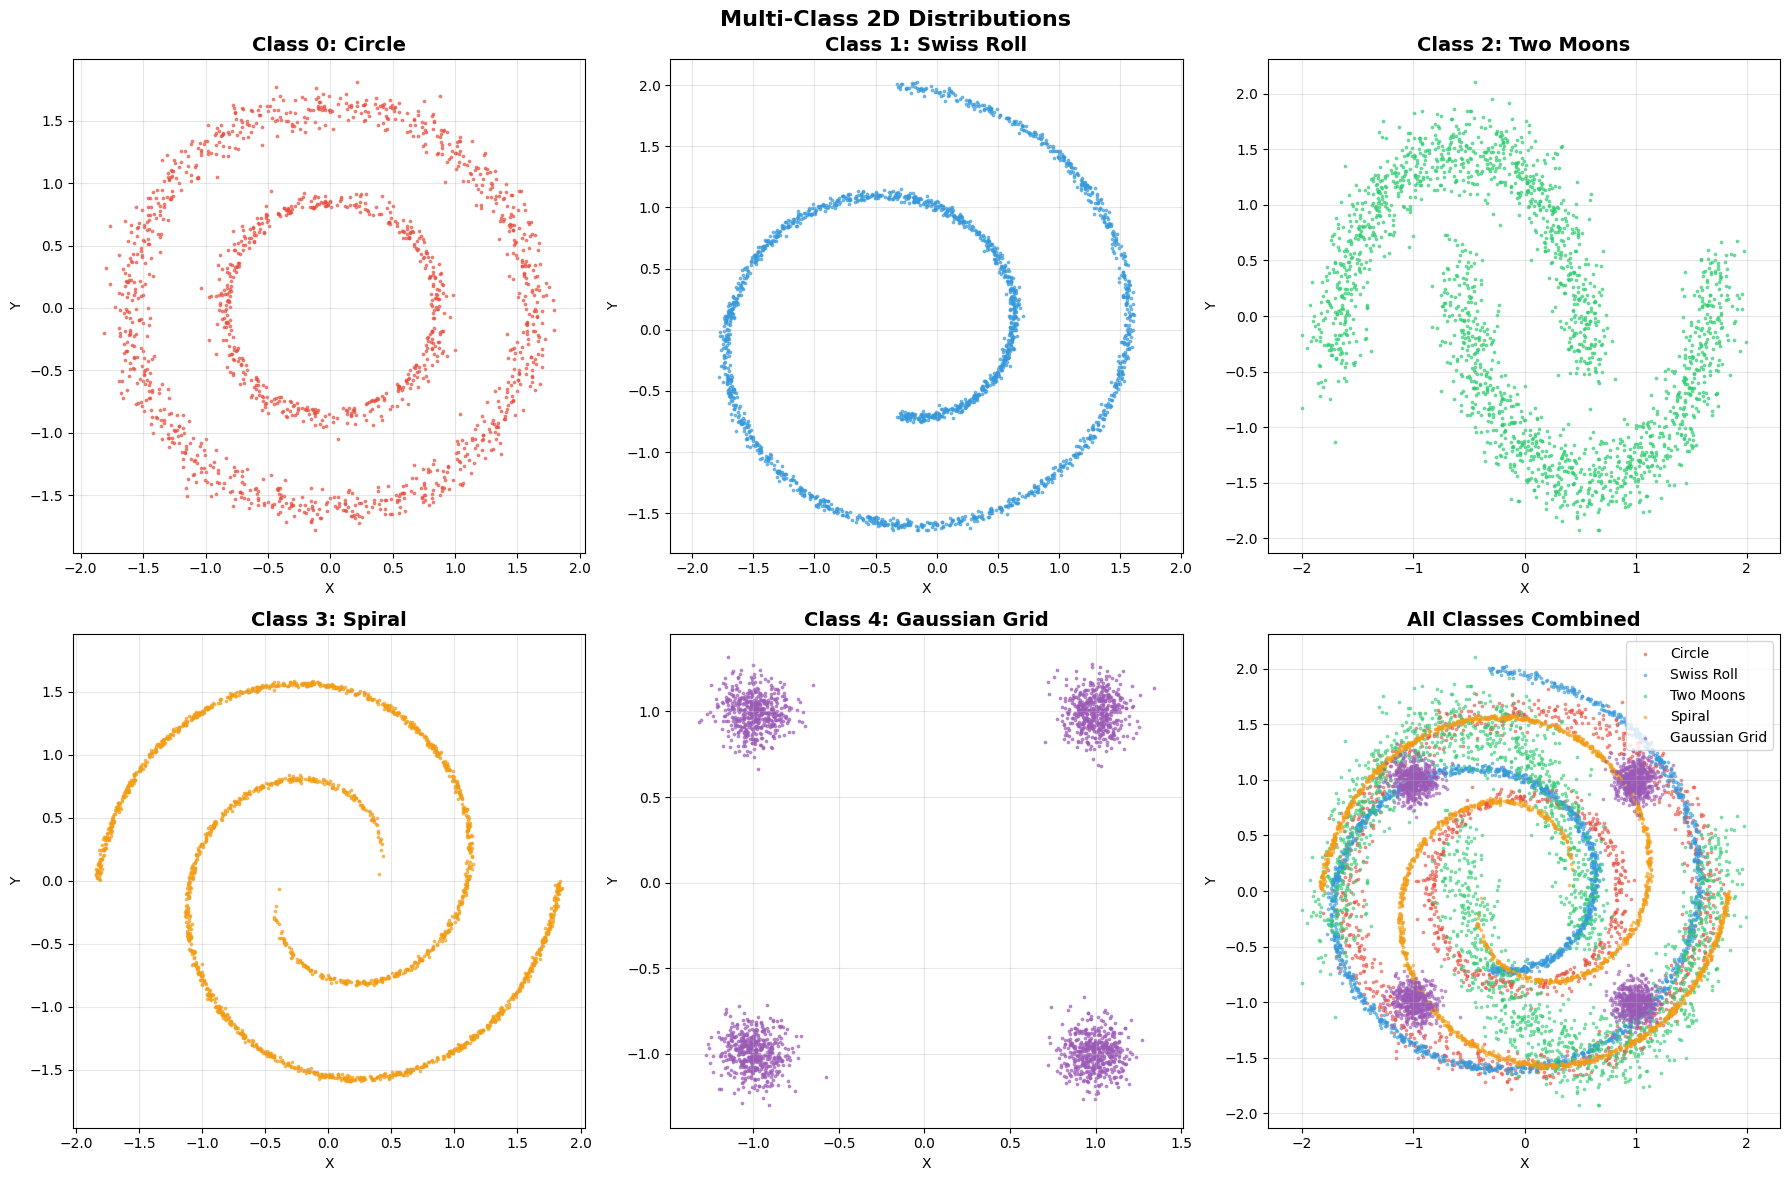

In [3]:
# Visualize all classes
class_names = ['Circle', 'Swiss Roll', 'Two Moons', 'Spiral', 'Gaussian Grid']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot each class separately
for class_idx in range(5):
    mask = y_labels == class_idx
    axes[class_idx].scatter(X_data[mask, 0], X_data[mask, 1], 
                           s=3, alpha=0.6, c=colors[class_idx])
    axes[class_idx].set_title(f'Class {class_idx}: {class_names[class_idx]}', 
                             fontsize=14, fontweight='bold')
    axes[class_idx].set_xlabel('X')
    axes[class_idx].set_ylabel('Y')
    axes[class_idx].grid(True, alpha=0.3)
    axes[class_idx].axis('equal')

# Plot all classes together
for class_idx in range(5):
    mask = y_labels == class_idx
    axes[5].scatter(X_data[mask, 0], X_data[mask, 1], 
                   s=3, alpha=0.5, c=colors[class_idx], label=class_names[class_idx])
axes[5].set_title('All Classes Combined', fontsize=14, fontweight='bold')
axes[5].set_xlabel('X')
axes[5].set_ylabel('Y')
axes[5].grid(True, alpha=0.3)
axes[5].axis('equal')
axes[5].legend(loc='upper right', fontsize=10)

plt.suptitle('Multi-Class 2D Distributions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 3. Model Architecture

We'll implement conditional versions of Generator and Discriminator using both **concatenation** and **embedding** approaches.

### Conditioning Strategies:

1. **Concatenation**: `[z; one_hot(y)]` - simple and effective
2. **Embedding**: Learn embeddings for class labels (more flexible)

For this notebook, we'll primarily use **concatenation with one-hot encoding** as it's most intuitive for visualization.

In [4]:
class ConditionalGenerator(nn.Module):
    """
    Conditional Generator: G(z, y) -> x
    
    Takes latent vector z and condition y, produces data x.
    
    Args:
        latent_dim: Dimension of latent noise vector z
        n_classes: Number of classes for conditioning
        data_dim: Dimension of output data
        hidden_sizes: List of hidden layer sizes
        use_embedding: If True, use learned embeddings; if False, use one-hot
        embed_dim: Dimension of learned embeddings (if use_embedding=True)
    """
    def __init__(
        self,
        latent_dim: int,
        n_classes: int,
        data_dim: int,
        hidden_sizes: List[int],
        use_embedding: bool = False,
        embed_dim: int = 10,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.use_embedding = use_embedding
        
        # Conditioning layer
        if use_embedding:
            self.label_embedding = nn.Embedding(n_classes, embed_dim)
            input_dim = latent_dim + embed_dim
        else:
            self.label_embedding = None
            input_dim = latent_dim + n_classes  # one-hot concatenation
        
        # Build MLP
        layers = []
        prev_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, data_dim))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, z: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Args:
            z: Latent vectors of shape (batch_size, latent_dim)
            labels: Class labels of shape (batch_size,) with values in [0, n_classes-1]
        
        Returns:
            Generated samples of shape (batch_size, data_dim)
        """
        if self.use_embedding:
            label_input = self.label_embedding(labels)
        else:
            # One-hot encode labels
            label_input = F.one_hot(labels, num_classes=self.n_classes).float()
        
        # Concatenate z and label
        gen_input = torch.cat([z, label_input], dim=1)
        return self.net(gen_input)


class ConditionalDiscriminator(nn.Module):
    """
    Conditional Discriminator: D(x, y) -> logit
    
    Takes data x and condition y, outputs a logit for real/fake classification.
    
    Args:
        data_dim: Dimension of input data
        n_classes: Number of classes for conditioning
        hidden_sizes: List of hidden layer sizes
        use_embedding: If True, use learned embeddings; if False, use one-hot
        embed_dim: Dimension of learned embeddings (if use_embedding=True)
    """
    def __init__(
        self,
        data_dim: int,
        n_classes: int,
        hidden_sizes: List[int],
        use_embedding: bool = False,
        embed_dim: int = 10,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.data_dim = data_dim
        self.n_classes = n_classes
        self.use_embedding = use_embedding
        
        # Conditioning layer
        if use_embedding:
            self.label_embedding = nn.Embedding(n_classes, embed_dim)
            input_dim = data_dim + embed_dim
        else:
            self.label_embedding = None
            input_dim = data_dim + n_classes  # one-hot concatenation
        
        # Build MLP
        layers = []
        prev_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Data samples of shape (batch_size, data_dim)
            labels: Class labels of shape (batch_size,) with values in [0, n_classes-1]
        
        Returns:
            Logits of shape (batch_size,)
        """
        if self.use_embedding:
            label_input = self.label_embedding(labels)
        else:
            # One-hot encode labels
            label_input = F.one_hot(labels, num_classes=self.n_classes).float()
        
        # Concatenate x and label
        disc_input = torch.cat([x, label_input], dim=1)
        return self.net(disc_input).view(-1)


def init_weights(m: nn.Module):
    """DCGAN-style weight initialization."""
    if isinstance(m, (nn.Linear, nn.Embedding)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)


# Test the models
latent_dim = 2
data_dim = 2
n_classes = 5
hidden_sizes = [128, 128, 128]

G = ConditionalGenerator(latent_dim, n_classes, data_dim, hidden_sizes, use_embedding=False).to(device)
D = ConditionalDiscriminator(data_dim, n_classes, hidden_sizes, use_embedding=False).to(device)

# Initialize weights
G.apply(init_weights)
D.apply(init_weights)

print("Conditional Generator Architecture:")
print(G)
print(f"\nGenerator parameters: {sum(p.numel() for p in G.parameters()):,}")
print(f"\nConditional Discriminator Architecture:")
print(D)
print(f"\nDiscriminator parameters: {sum(p.numel() for p in D.parameters()):,}")

# Test forward pass
z = torch.randn(5, latent_dim).to(device)
labels = torch.randint(0, n_classes, (5,)).to(device)
fake_samples = G(z, labels)
logits = D(fake_samples, labels)
print(f"\nTest: z.shape={z.shape}, labels.shape={labels.shape}")
print(f"  -> G(z, y).shape={fake_samples.shape}")
print(f"  -> D(G(z, y), y).shape={logits.shape}")
print(f"\nTest labels: {labels.cpu().numpy()}")

Conditional Generator Architecture:
ConditionalGenerator(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

Generator parameters: 34,306

Conditional Discriminator Architecture:
ConditionalDiscriminator(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): LeakyReLU(negativ

---
## 4. Training Process

The training loop for cGAN is similar to vanilla GAN, but we now pass labels to both networks.

**Key differences**:
- Sample random labels along with random noise for generator
- Pass true labels with real data to discriminator
- Discriminator must learn: "Is this sample real AND does it match the label?"

In [5]:
def train_conditional_gan(
    data: np.ndarray,
    labels: np.ndarray,
    latent_dim: int = 2,
    hidden_sizes: List[int] = [128, 128, 128],
    batch_size: int = 128,
    n_steps: int = 20000,
    lr: float = 1e-4,
    beta1: float = 0.5,
    beta2: float = 0.999,
    n_disc: int = 1,
    real_label_smoothing: float = 0.9,
    use_embedding: bool = False,
    print_every: int = 1000,
    save_samples_every: int = 2000,
    device: torch.device = device,
) -> Tuple[ConditionalGenerator, ConditionalDiscriminator, dict]:
    """
    Train a conditional GAN on multi-class 2D data.
    
    Args:
        data: Training data of shape (n_samples, 2)
        labels: Class labels of shape (n_samples,)
        latent_dim: Dimension of latent space
        hidden_sizes: Hidden layer sizes for both G and D
        batch_size: Batch size for training
        n_steps: Number of training steps
        lr: Learning rate
        beta1, beta2: Adam optimizer betas
        n_disc: Number of discriminator updates per generator update
        real_label_smoothing: Value for real labels
        use_embedding: Use learned embeddings vs one-hot encoding
        print_every: Print statistics every N steps
        save_samples_every: Save generated samples every N steps
        device: Device to train on
    
    Returns:
        Trained generator, discriminator, and training history
    """
    data_dim = data.shape[1]
    n_classes = len(np.unique(labels))
    
    # Create data loader
    dataset = TensorDataset(
        torch.tensor(data, dtype=torch.float32),
        torch.tensor(labels, dtype=torch.long)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize models
    G = ConditionalGenerator(latent_dim, n_classes, data_dim, hidden_sizes, 
                             use_embedding=use_embedding).to(device)
    D = ConditionalDiscriminator(data_dim, n_classes, hidden_sizes, 
                                 use_embedding=use_embedding).to(device)
    G.apply(init_weights)
    D.apply(init_weights)
    
    # Optimizers
    g_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
    d_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
    
    # Loss function
    bce = nn.BCEWithLogitsLoss()
    
    # Helper functions
    def sample_z(n):
        return torch.randn(n, latent_dim, device=device)
    
    def sample_labels(n):
        return torch.randint(0, n_classes, (n,), device=device)
    
    # Training history
    history = {
        'g_loss': [],
        'd_loss': [],
        'd_real': [],
        'd_fake': [],
        'samples_per_class': [],  # Will store samples for each class
        'steps': []
    }
    
    # Training loop
    it = iter(loader)
    for step in range(1, n_steps + 1):
        # ===== Discriminator training =====
        d_loss_acc = 0.0
        d_real_acc = 0.0
        d_fake_acc = 0.0
        
        for _ in range(n_disc):
            # Get real data with labels
            try:
                real, real_labels = next(it)
                real = real.to(device)
                real_labels = real_labels.to(device)
            except StopIteration:
                it = iter(loader)
                real, real_labels = next(it)
                real = real.to(device)
                real_labels = real_labels.to(device)
            
            # Generate fake data with random labels
            z = sample_z(len(real))
            fake_labels = sample_labels(len(real))
            fake = G(z, fake_labels).detach()
            
            # Discriminator predictions
            d_real_logits = D(real, real_labels)
            d_fake_logits = D(fake, fake_labels)
            
            # Losses
            y_real = torch.full_like(d_real_logits, real_label_smoothing)
            y_fake = torch.zeros_like(d_fake_logits)
            
            loss_real = bce(d_real_logits, y_real)
            loss_fake = bce(d_fake_logits, y_fake)
            d_loss = loss_real + loss_fake
            
            # Update discriminator
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()
            
            # Accumulate for logging
            d_loss_acc += d_loss.item()
            d_real_acc += torch.sigmoid(d_real_logits).mean().item()
            d_fake_acc += torch.sigmoid(d_fake_logits).mean().item()
        
        avg_d_loss = d_loss_acc / n_disc
        avg_d_real = d_real_acc / n_disc
        avg_d_fake = d_fake_acc / n_disc
        
        # ===== Generator training =====
        z = sample_z(batch_size)
        gen_labels = sample_labels(batch_size)
        fake = G(z, gen_labels)
        g_logits = D(fake, gen_labels)
        
        # Non-saturating loss
        y_gen = torch.ones_like(g_logits)
        g_loss = bce(g_logits, y_gen)
        
        # Update generator
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        # ===== Logging =====
        history['g_loss'].append(g_loss.item())
        history['d_loss'].append(avg_d_loss)
        history['d_real'].append(avg_d_real)
        history['d_fake'].append(avg_d_fake)
        history['steps'].append(step)
        
        if step % print_every == 0 or step == 1:
            print(f"[{step:5d}/{n_steps}] D_loss={avg_d_loss:.4f} | G_loss={g_loss.item():.4f} | "
                  f"D(real)={avg_d_real:.3f} | D(fake)={avg_d_fake:.3f}")
        
        # Save samples for each class
        if step % save_samples_every == 0 or step == 1:
            with torch.no_grad():
                samples_dict = {}
                for class_idx in range(n_classes):
                    z_class = sample_z(1000)
                    labels_class = torch.full((1000,), class_idx, dtype=torch.long, device=device)
                    samples_class = G(z_class, labels_class).cpu().numpy()
                    samples_dict[class_idx] = samples_class
                history['samples_per_class'].append(samples_dict)
    
    return G, D, history

### Train the Conditional GAN

In [6]:
print("Training Conditional GAN on multi-class data...\n")
G_cond, D_cond, history_cond = train_conditional_gan(
    data=X_data,
    labels=y_labels,
    latent_dim=2,
    hidden_sizes=[128, 128, 128],
    batch_size=128,
    n_steps=20000,
    lr=1e-4,
    use_embedding=False,
    print_every=2000,
    save_samples_every=2000,
    device=device
)
print("\nTraining complete!")

Training Conditional GAN on multi-class data...

[    1/20000] D_loss=1.3863 | G_loss=0.6933 | D(real)=0.500 | D(fake)=0.500
[ 2000/20000] D_loss=1.3494 | G_loss=0.8796 | D(real)=0.463 | D(fake)=0.435
[ 4000/20000] D_loss=1.3298 | G_loss=0.8862 | D(real)=0.497 | D(fake)=0.442
[ 6000/20000] D_loss=1.3135 | G_loss=0.9571 | D(real)=0.481 | D(fake)=0.421
[ 8000/20000] D_loss=1.3204 | G_loss=0.8933 | D(real)=0.470 | D(fake)=0.419
[10000/20000] D_loss=1.3340 | G_loss=0.8631 | D(real)=0.471 | D(fake)=0.435
[12000/20000] D_loss=1.3764 | G_loss=0.8085 | D(real)=0.463 | D(fake)=0.458
[14000/20000] D_loss=1.3511 | G_loss=0.7872 | D(real)=0.467 | D(fake)=0.449
[16000/20000] D_loss=1.3658 | G_loss=0.8199 | D(real)=0.457 | D(fake)=0.448
[18000/20000] D_loss=1.3624 | G_loss=0.8196 | D(real)=0.451 | D(fake)=0.440
[20000/20000] D_loss=1.3761 | G_loss=0.8023 | D(real)=0.454 | D(fake)=0.451

Training complete!


### Training Curves

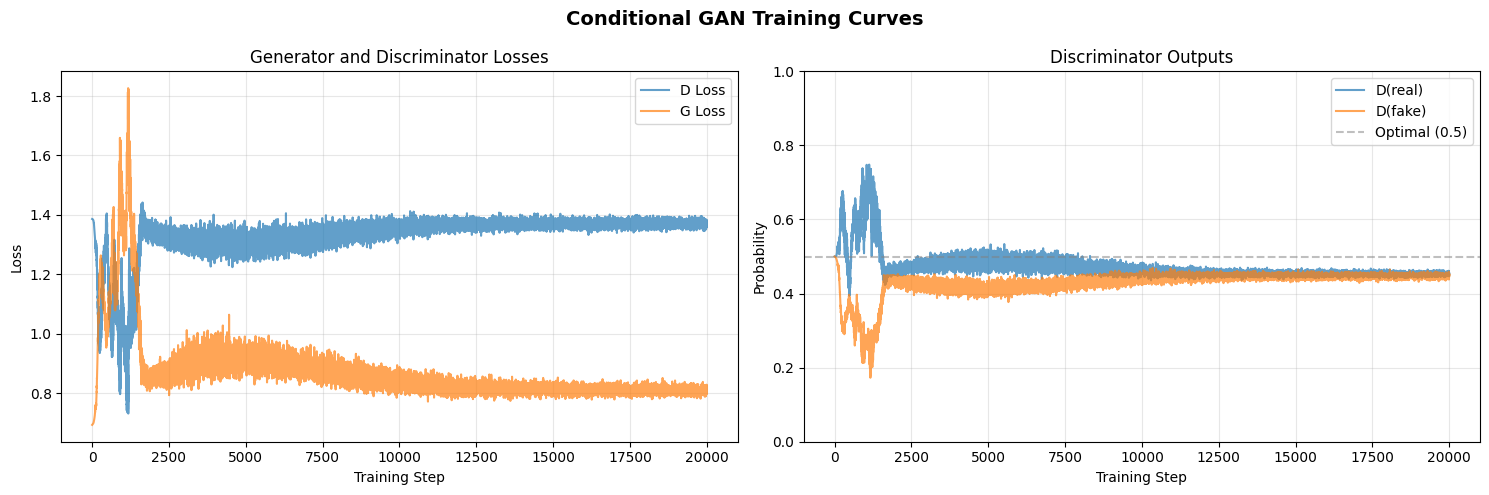

In [7]:
def plot_training_curves(history, title="Training Curves"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    steps = history['steps']
    
    # Plot losses
    axes[0].plot(steps, history['d_loss'], label='D Loss', alpha=0.7, linewidth=1.5)
    axes[0].plot(steps, history['g_loss'], label='G Loss', alpha=0.7, linewidth=1.5)
    axes[0].set_xlabel('Training Step')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Generator and Discriminator Losses')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot discriminator outputs
    axes[1].plot(steps, history['d_real'], label='D(real)', alpha=0.7, linewidth=1.5)
    axes[1].plot(steps, history['d_fake'], label='D(fake)', alpha=0.7, linewidth=1.5)
    axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Optimal (0.5)')
    axes[1].set_xlabel('Training Step')
    axes[1].set_ylabel('Probability')
    axes[1].set_title('Discriminator Outputs')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_curves(history_cond, "Conditional GAN Training Curves")

---
## 5. Conditional Generation

The key feature of cGAN: **we can control what gets generated** by specifying the class label!

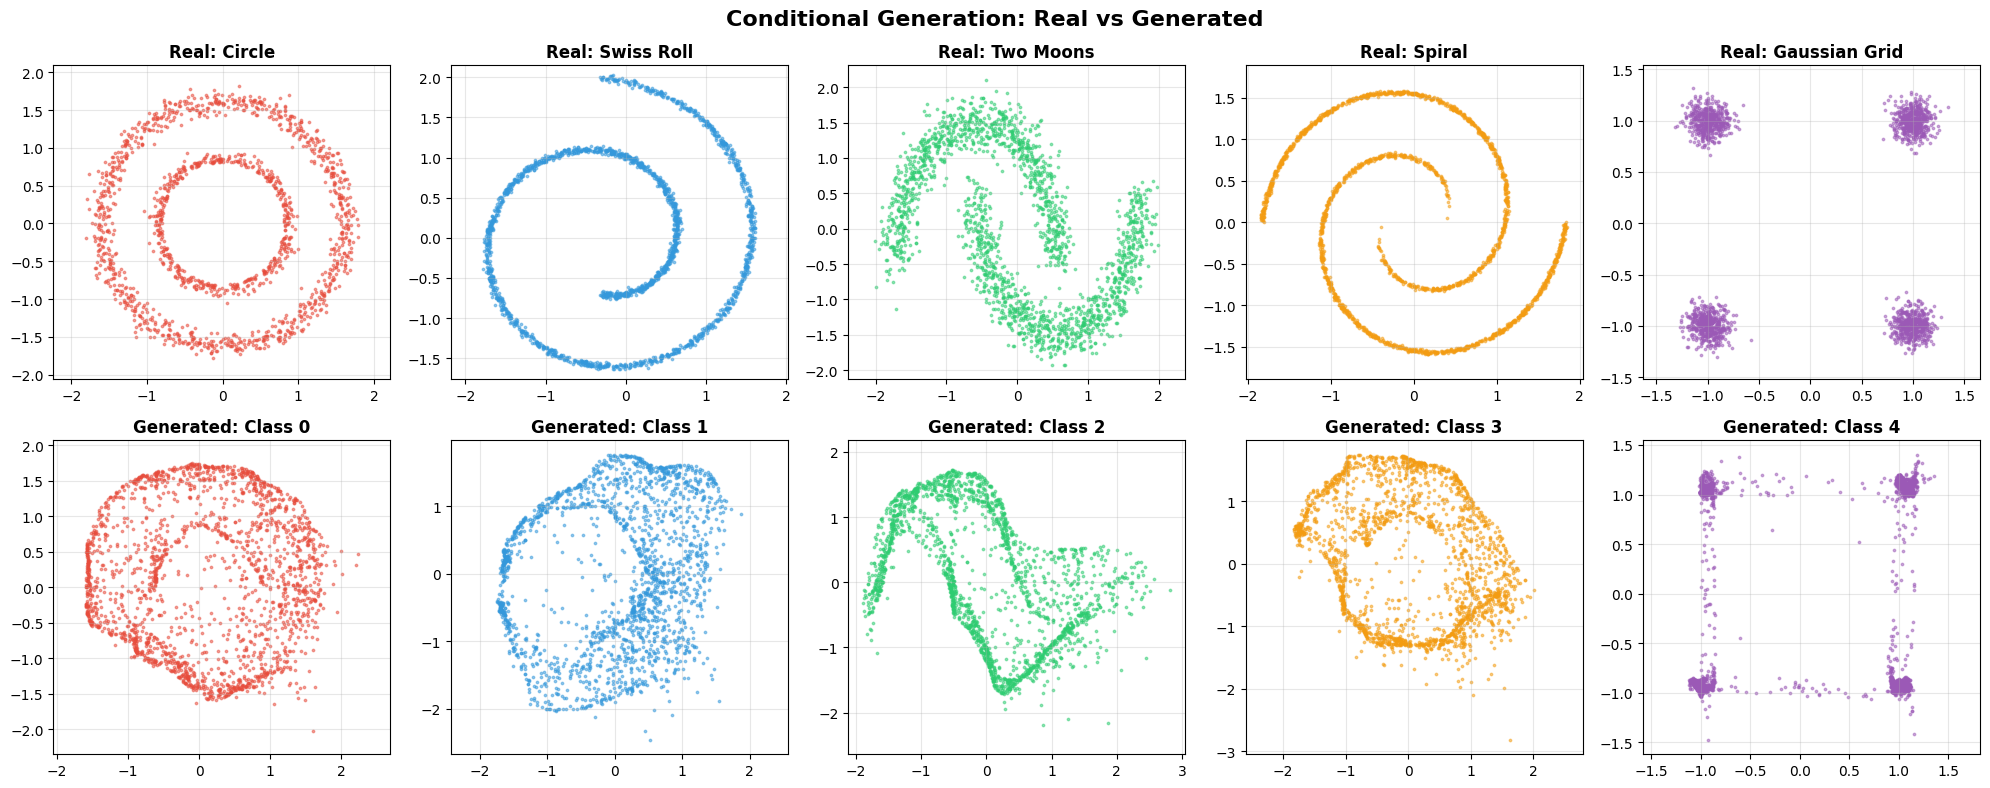

In [8]:
# Generate samples for each class
n_samples_per_class = 2000
generated_samples = {}

with torch.no_grad():
    for class_idx in range(5):
        z = torch.randn(n_samples_per_class, 2).to(device)
        labels = torch.full((n_samples_per_class,), class_idx, dtype=torch.long, device=device)
        samples = G_cond(z, labels).cpu().numpy()
        generated_samples[class_idx] = samples

# Visualize generated samples vs real data
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for class_idx in range(5):
    # Real data (top row)
    mask = y_labels == class_idx
    axes[0, class_idx].scatter(X_data[mask, 0], X_data[mask, 1], 
                              s=3, alpha=0.5, c=colors[class_idx])
    axes[0, class_idx].set_title(f'Real: {class_names[class_idx]}', fontweight='bold')
    axes[0, class_idx].axis('equal')
    axes[0, class_idx].grid(True, alpha=0.3)
    
    # Generated data (bottom row)
    gen_samples = generated_samples[class_idx]
    axes[1, class_idx].scatter(gen_samples[:, 0], gen_samples[:, 1], 
                              s=3, alpha=0.5, c=colors[class_idx])
    axes[1, class_idx].set_title(f'Generated: Class {class_idx}', fontweight='bold')
    axes[1, class_idx].axis('equal')
    axes[1, class_idx].grid(True, alpha=0.3)

plt.suptitle('Conditional Generation: Real vs Generated', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

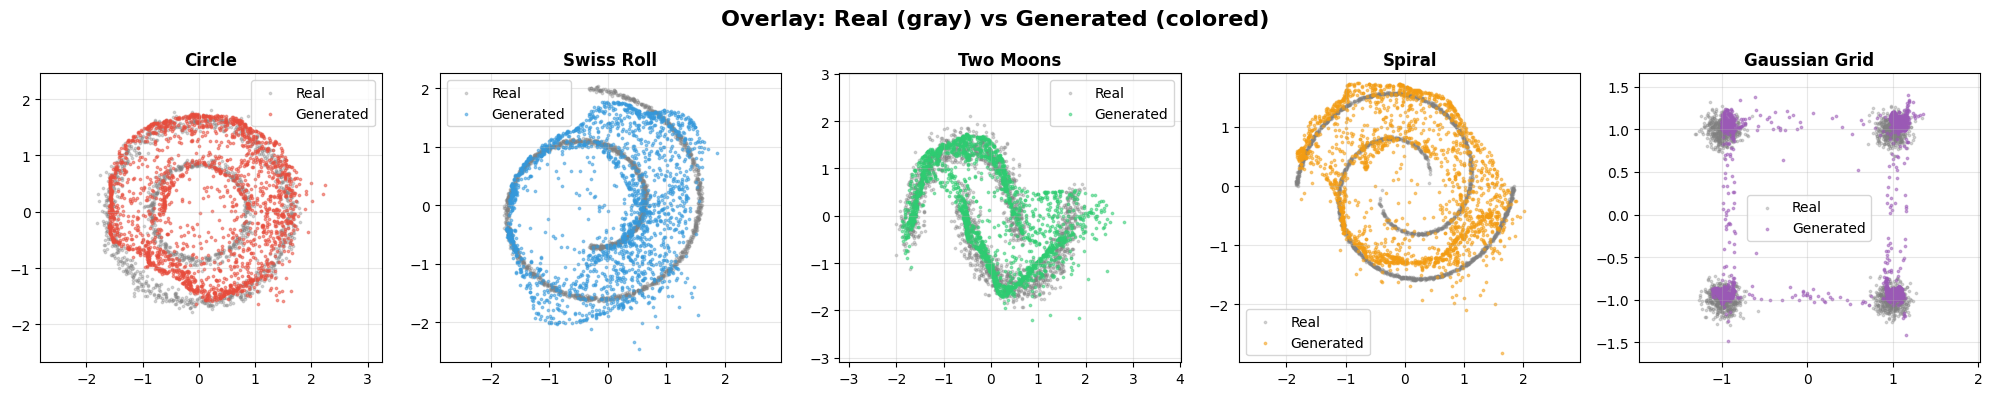

In [9]:
# Overlay comparison for each class
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for class_idx in range(5):
    # Real data
    mask = y_labels == class_idx
    axes[class_idx].scatter(X_data[mask, 0], X_data[mask, 1], 
                           s=3, alpha=0.3, c='gray', label='Real')
    
    # Generated data
    gen_samples = generated_samples[class_idx]
    axes[class_idx].scatter(gen_samples[:, 0], gen_samples[:, 1], 
                           s=3, alpha=0.5, c=colors[class_idx], label='Generated')
    
    axes[class_idx].set_title(f'{class_names[class_idx]}', fontweight='bold')
    axes[class_idx].axis('equal')
    axes[class_idx].grid(True, alpha=0.3)
    axes[class_idx].legend()

plt.suptitle('Overlay: Real (gray) vs Generated (colored)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Training Progression for Each Class

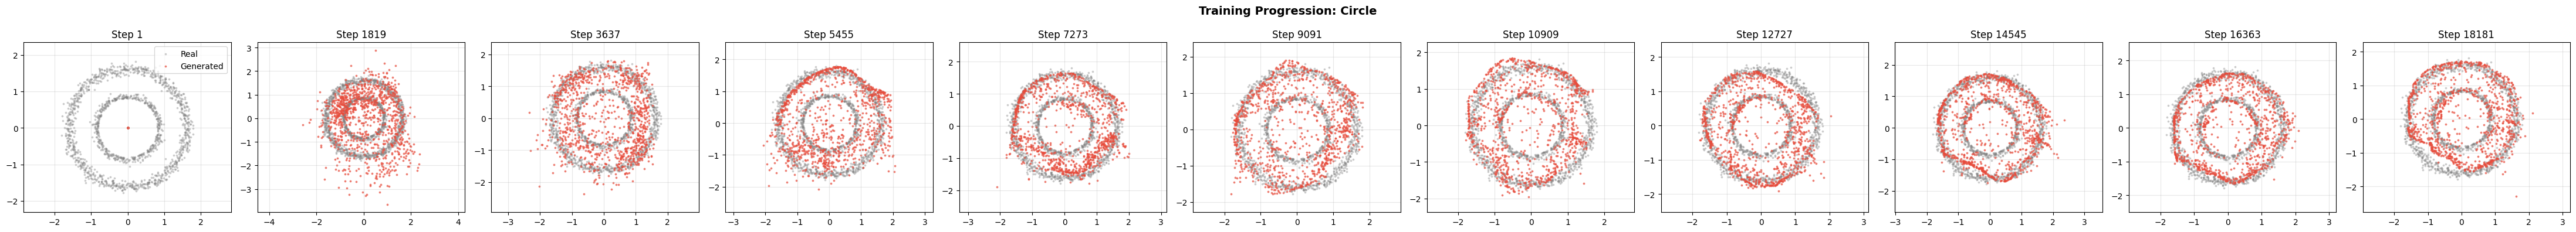

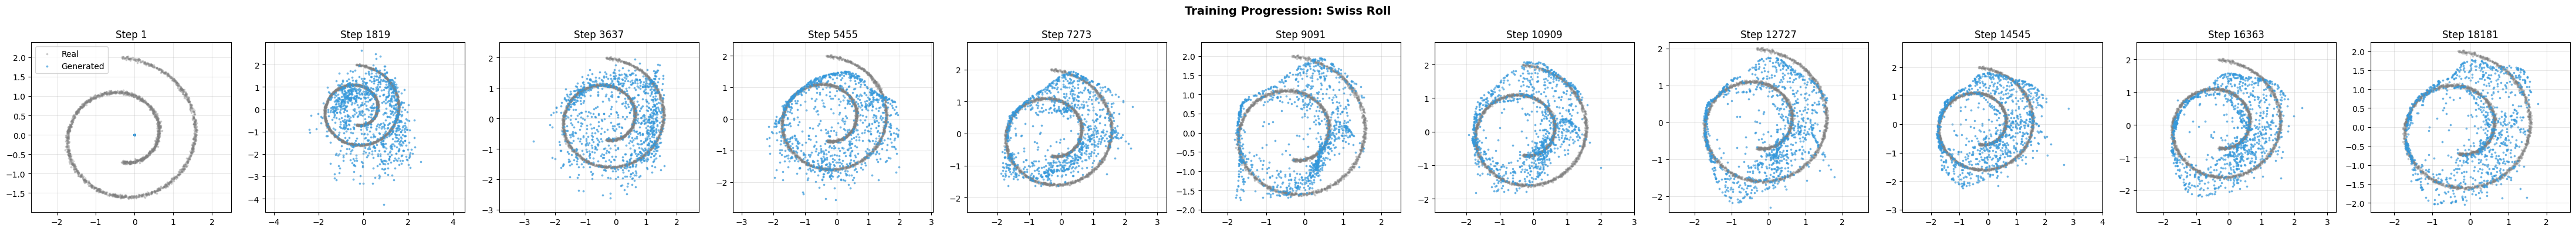

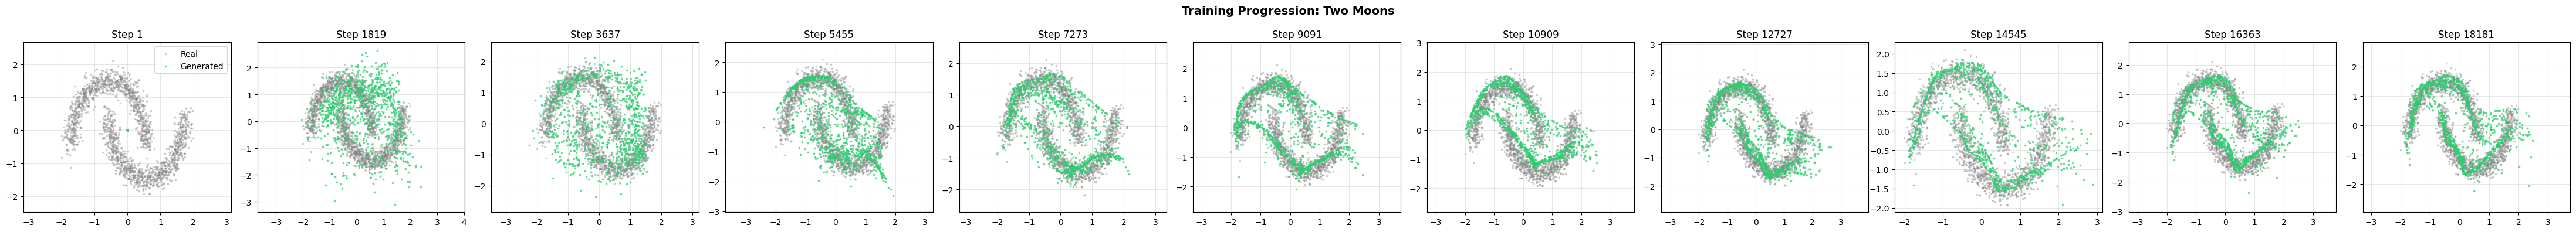

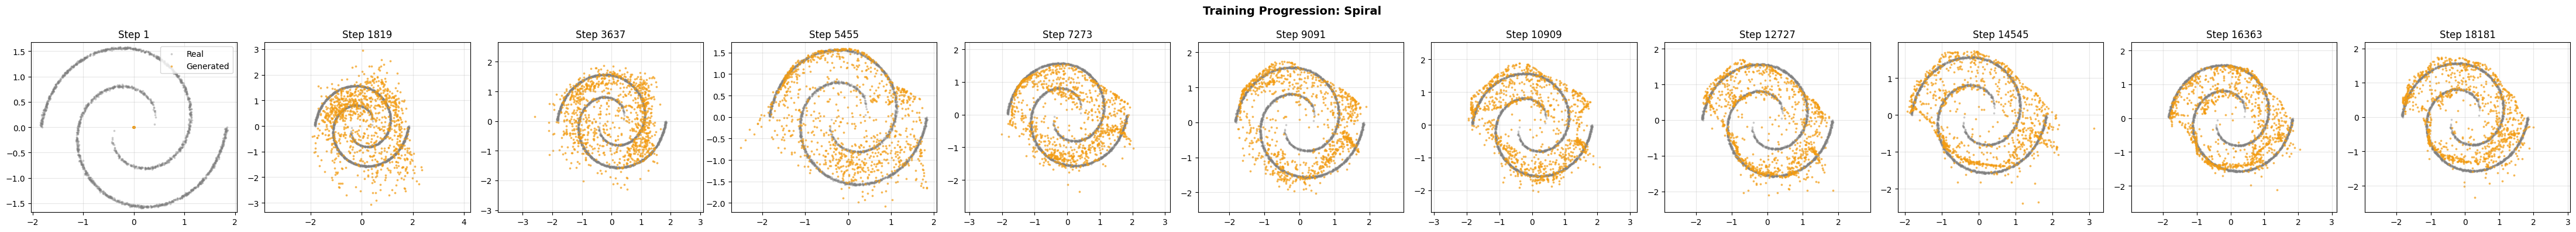

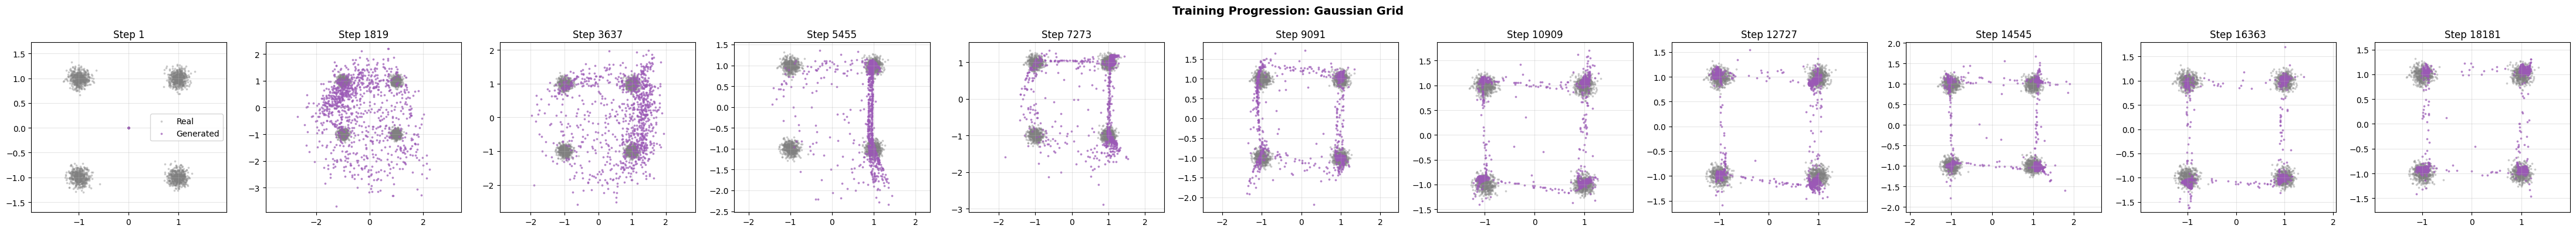

In [10]:
def plot_class_progression(class_idx, history, real_data, real_labels, class_name):
    """
    Plot how the generator learns to produce a specific class over time.
    """
    snapshots = history['samples_per_class']
    n_snapshots = len(snapshots)
    
    fig, axes = plt.subplots(1, n_snapshots, figsize=(4*n_snapshots, 4))
    if n_snapshots == 1:
        axes = [axes]
    
    # Real data for this class
    mask = real_labels == class_idx
    real_class = real_data[mask]
    
    for idx, (ax, snapshot) in enumerate(zip(axes, snapshots)):
        samples = snapshot[class_idx]
        
        # Plot real data in background
        ax.scatter(real_class[:, 0], real_class[:, 1], 
                  s=3, alpha=0.3, c='gray', label='Real')
        # Plot generated samples
        ax.scatter(samples[:, 0], samples[:, 1], 
                  s=3, alpha=0.6, c=colors[class_idx], label='Generated')
        
        step_idx = idx * (len(history['steps']) // n_snapshots)
        step = history['steps'][step_idx]
        ax.set_title(f'Step {step}', fontsize=12)
        ax.axis('equal')
        if idx == 0:
            ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Training Progression: {class_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot progression for each class
for class_idx in range(5):
    plot_class_progression(class_idx, history_cond, X_data, y_labels, class_names[class_idx])

---
## 6. Analysis & Evaluation

Let's quantitatively evaluate how well the cGAN learned each distribution.

In [11]:
def evaluate_class_quality(real_data, generated_data, class_idx, class_name):
    """
    Compute quality metrics for a specific class.
    """
    # KS test for both dimensions
    ks_stat_0, ks_pval_0 = stats.ks_2samp(real_data[:, 0], generated_data[:, 0])
    ks_stat_1, ks_pval_1 = stats.ks_2samp(real_data[:, 1], generated_data[:, 1])
    
    # Mean and std comparison
    real_mean = real_data.mean(axis=0)
    gen_mean = generated_data.mean(axis=0)
    real_std = real_data.std(axis=0)
    gen_std = generated_data.std(axis=0)
    
    print(f"\n{'='*60}")
    print(f"Class {class_idx}: {class_name}")
    print(f"{'='*60}")
    print(f"KS Statistic (dim 0): {ks_stat_0:.4f} (p-value: {ks_pval_0:.4f})")
    print(f"KS Statistic (dim 1): {ks_stat_1:.4f} (p-value: {ks_pval_1:.4f})")
    print(f"\nMean - Real: {real_mean}, Generated: {gen_mean}")
    print(f"Std  - Real: {real_std}, Generated: {gen_std}")
    
    return {
        'ks_stat_0': ks_stat_0,
        'ks_stat_1': ks_stat_1,
        'ks_pval_0': ks_pval_0,
        'ks_pval_1': ks_pval_1
    }

# Evaluate all classes
class_metrics = {}
for class_idx in range(5):
    mask = y_labels == class_idx
    real_class_data = X_data[mask]
    gen_class_data = generated_samples[class_idx]
    
    metrics = evaluate_class_quality(real_class_data, gen_class_data, 
                                     class_idx, class_names[class_idx])
    class_metrics[class_idx] = metrics


Class 0: Circle
KS Statistic (dim 0): 0.0520 (p-value: 0.0184)
KS Statistic (dim 1): 0.0767 (p-value: 0.0001)

Mean - Real: [1.24014274e-17 1.76425068e-17], Generated: [0.07057125 0.12101786]
Std  - Real: [1. 1.], Generated: [0.97806424 0.97736955]

Class 1: Swiss Roll
KS Statistic (dim 0): 0.0725 (p-value: 0.0001)
KS Statistic (dim 1): 0.0910 (p-value: 0.0000)

Mean - Real: [ 8.40993941e-18 -2.70894418e-17], Generated: [ 0.00956282 -0.00035033]
Std  - Real: [1. 1.], Generated: [0.9177523 1.0653679]

Class 2: Two Moons
KS Statistic (dim 0): 0.0400 (p-value: 0.0815)
KS Statistic (dim 1): 0.0510 (p-value: 0.0110)

Mean - Real: [1.41525680e-16 6.82898182e-16], Generated: [-0.02405353  0.07241438]
Std  - Real: [1. 1.], Generated: [1.0014479  0.96893436]

Class 3: Spiral
KS Statistic (dim 0): 0.0420 (p-value: 0.0587)
KS Statistic (dim 1): 0.1045 (p-value: 0.0000)

Mean - Real: [3.73034936e-17 1.14130927e-16], Generated: [0.01918485 0.09776861]
Std  - Real: [1. 1.], Generated: [0.9680979  0

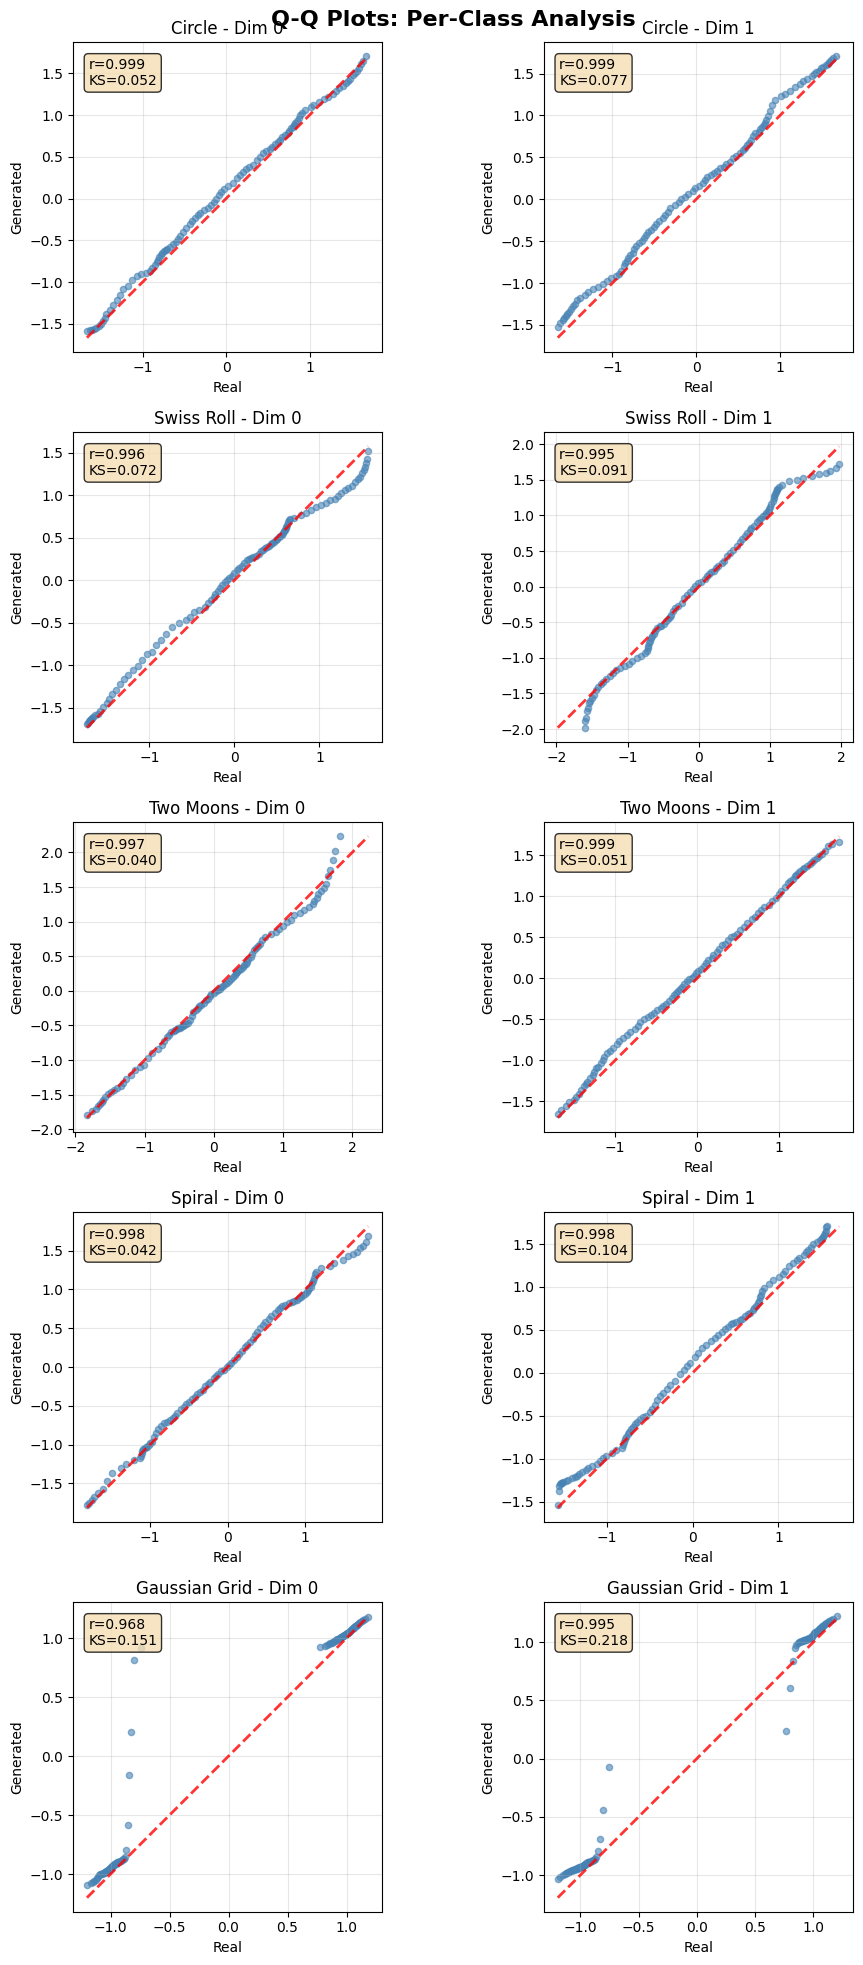

In [12]:
def qqplot(x, y, ax, title):
    """Simple Q-Q plot."""
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    n_quantiles = min(len(x), len(y), 100)
    quantiles = np.linspace(0.01, 0.99, n_quantiles)
    x_quantiles = np.quantile(x, quantiles)
    y_quantiles = np.quantile(y, quantiles)
    
    ax.scatter(x_quantiles, y_quantiles, alpha=0.6, s=20, color='steelblue')
    
    min_val = min(np.min(x_quantiles), np.min(y_quantiles))
    max_val = max(np.max(x_quantiles), np.max(y_quantiles))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    
    correlation = np.corrcoef(x_quantiles, y_quantiles)[0, 1]
    ks_stat, ks_pval = stats.ks_2samp(x, y)
    
    stats_text = f'r={correlation:.3f}\nKS={ks_stat:.3f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.set_xlabel('Real')
    ax.set_ylabel('Generated')
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)

# Q-Q plots for all classes
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for class_idx in range(5):
    mask = y_labels == class_idx
    real_class_data = X_data[mask]
    gen_class_data = generated_samples[class_idx]
    
    # Dimension 0
    qqplot(real_class_data[:, 0], gen_class_data[:, 0], axes[class_idx, 0],
           f'{class_names[class_idx]} - Dim 0')
    
    # Dimension 1
    qqplot(real_class_data[:, 1], gen_class_data[:, 1], axes[class_idx, 1],
           f'{class_names[class_idx]} - Dim 1')

plt.suptitle('Q-Q Plots: Per-Class Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 7. Interactive Experiments

### Experiment 1: Latent Space Interpolation with Fixed Condition

What happens when we interpolate in latent space while keeping the class fixed?

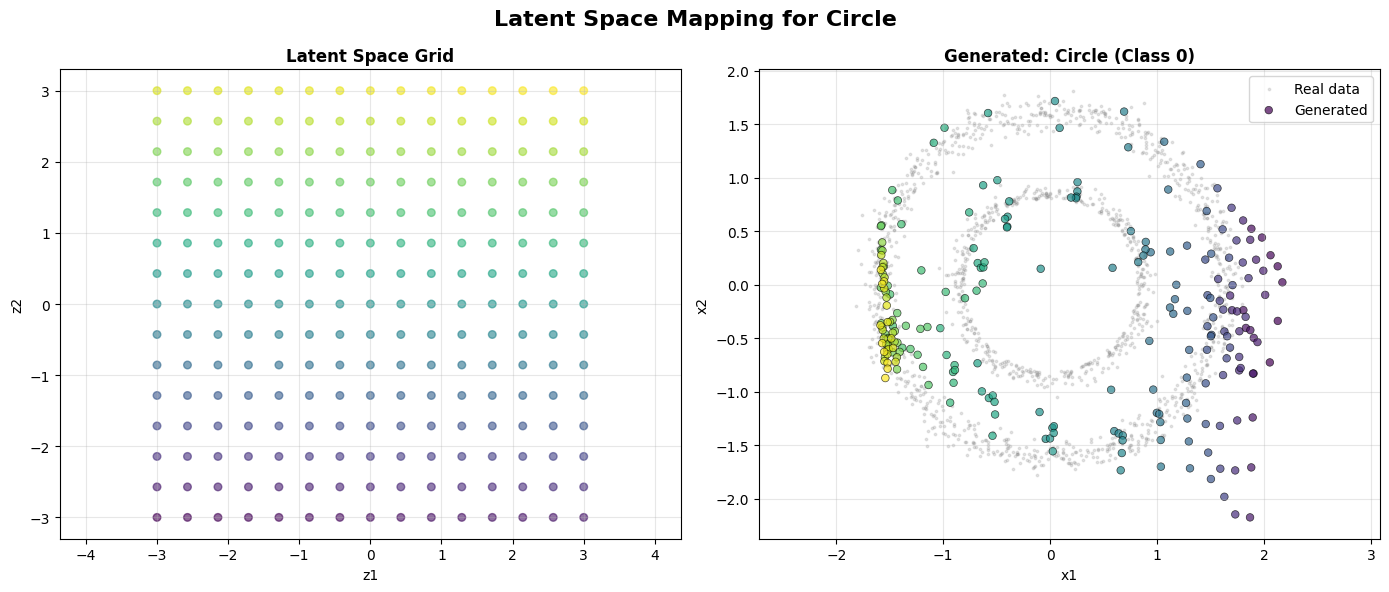

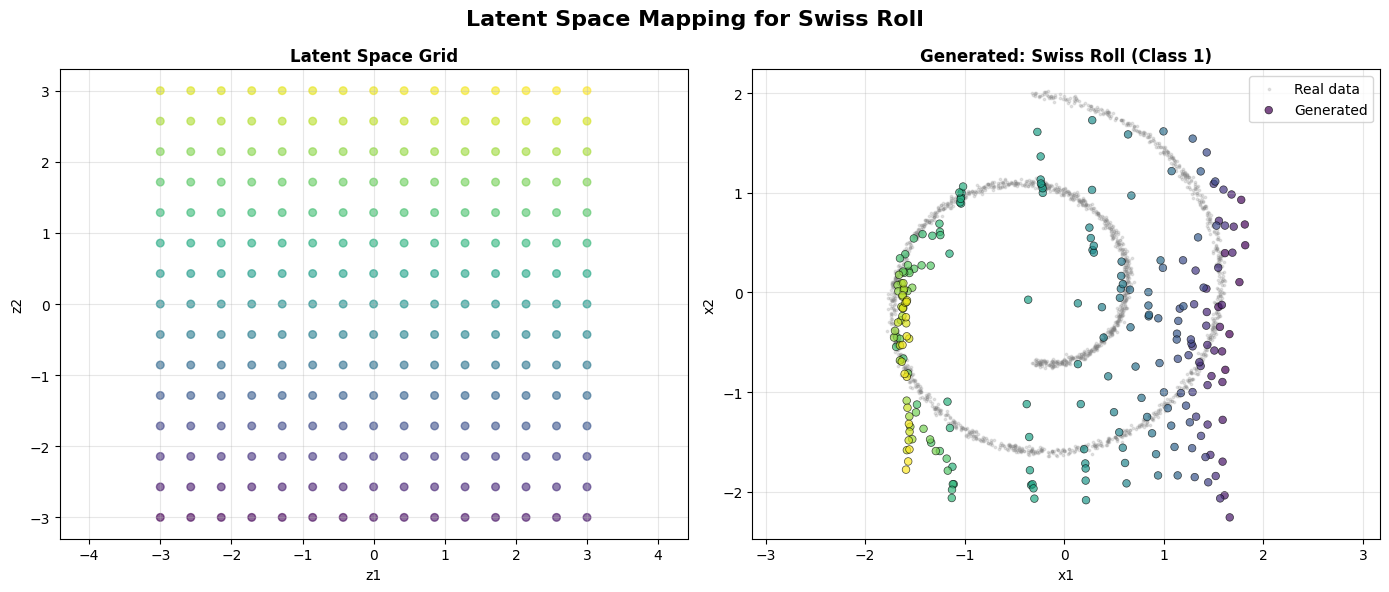

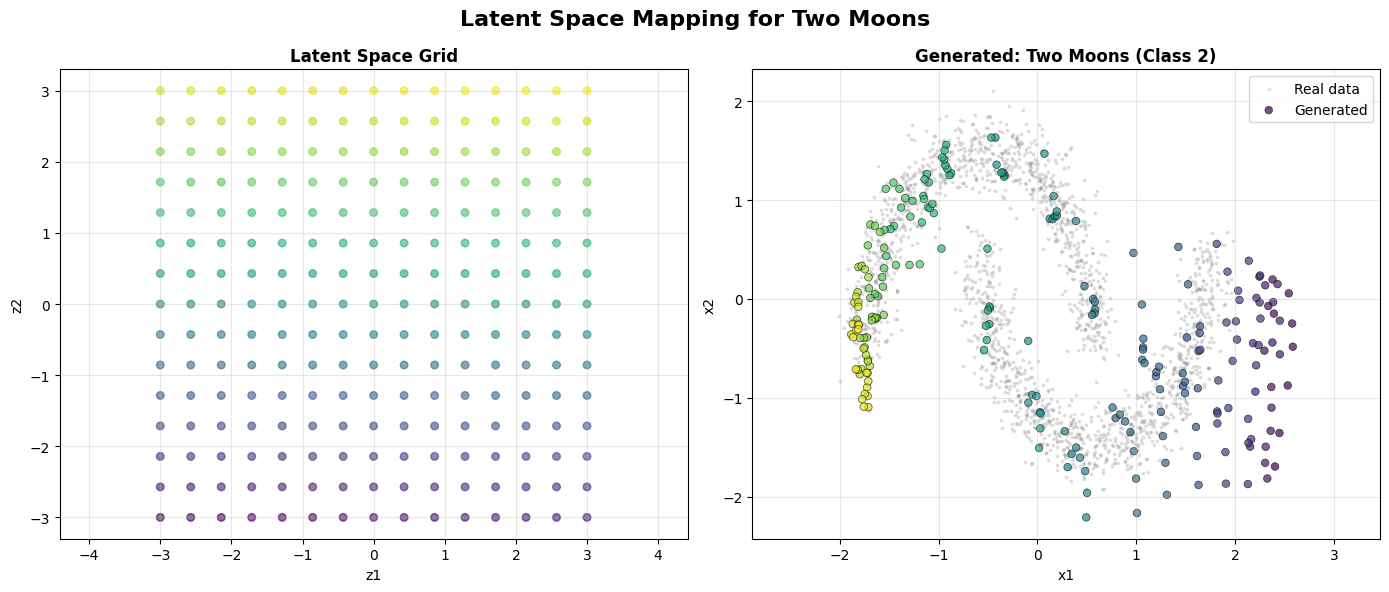

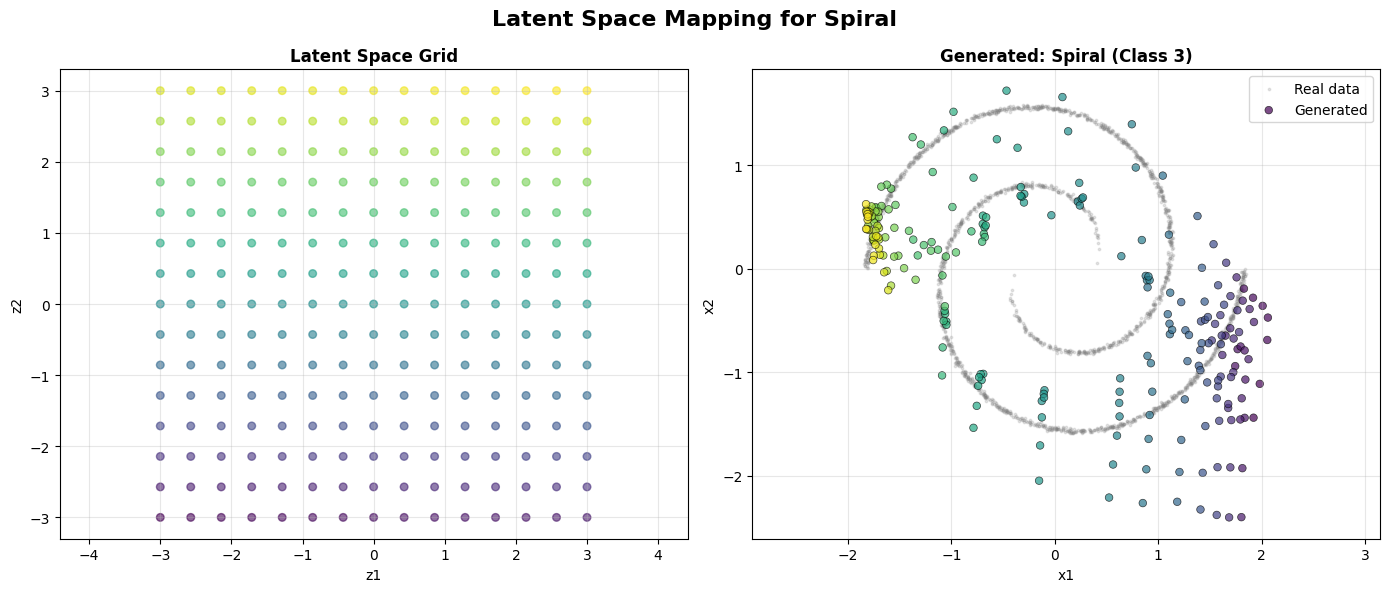

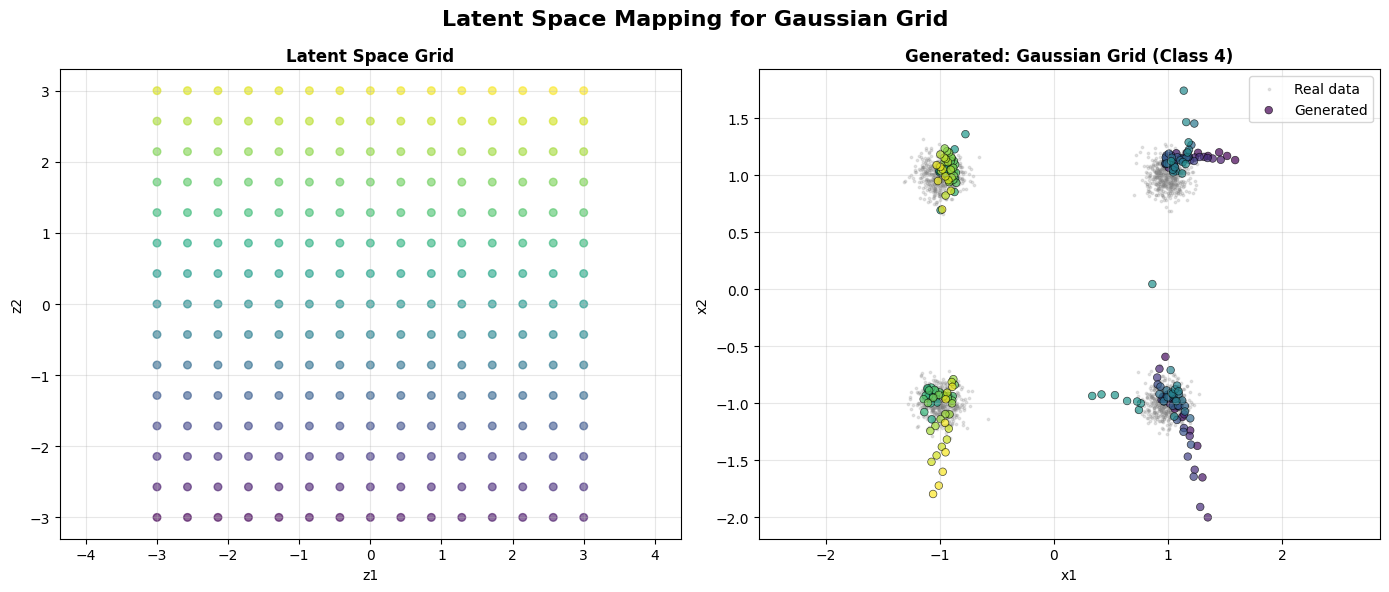

In [13]:
def visualize_latent_interpolation(G, class_idx, class_name, n_points=15):
    """
    Visualize interpolation in latent space for a fixed class.
    """
    # Create a grid in latent space
    x = np.linspace(-3, 3, n_points)
    y = np.linspace(-3, 3, n_points)
    xx, yy = np.meshgrid(x, y)
    z_grid = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Generate samples with fixed class
    with torch.no_grad():
        z_tensor = torch.tensor(z_grid, dtype=torch.float32).to(device)
        labels = torch.full((len(z_grid),), class_idx, dtype=torch.long, device=device)
        generated = G(z_tensor, labels).cpu().numpy()
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Latent space
    axes[0].scatter(z_grid[:, 0], z_grid[:, 1], c=np.arange(len(z_grid)), 
                   cmap='viridis', s=30, alpha=0.6)
    axes[0].set_title(f'Latent Space Grid', fontweight='bold')
    axes[0].set_xlabel('z1')
    axes[0].set_ylabel('z2')
    axes[0].axis('equal')
    axes[0].grid(True, alpha=0.3)
    
    # Data space
    mask = y_labels == class_idx
    axes[1].scatter(X_data[mask, 0], X_data[mask, 1], s=3, alpha=0.2, c='gray', label='Real data')
    axes[1].scatter(generated[:, 0], generated[:, 1], c=np.arange(len(generated)), 
                   cmap='viridis', s=30, alpha=0.7, edgecolors='black', linewidth=0.5, label='Generated')
    axes[1].set_title(f'Generated: {class_name} (Class {class_idx})', fontweight='bold')
    axes[1].set_xlabel('x1')
    axes[1].set_ylabel('x2')
    axes[1].axis('equal')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.suptitle(f'Latent Space Mapping for {class_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize for each class
for class_idx in range(5):
    visualize_latent_interpolation(G_cond, class_idx, class_names[class_idx])

### Experiment 2: What Happens with Wrong Labels?

What if we feed the discriminator real data but with incorrect labels?

In [14]:
print("Testing Discriminator with Correct vs Incorrect Labels\n")

# Take real samples from class 0 (Circle)
class_idx = 0
mask = y_labels == class_idx
real_samples = torch.tensor(X_data[mask][:100], dtype=torch.float32).to(device)

with torch.no_grad():
    # Test with correct label
    correct_labels = torch.full((100,), class_idx, dtype=torch.long, device=device)
    logits_correct = D_cond(real_samples, correct_labels)
    probs_correct = torch.sigmoid(logits_correct).mean().item()
    
    print(f"Real {class_names[class_idx]} samples with CORRECT label (class {class_idx}):")
    print(f"  Average D(x, y) = {probs_correct:.3f}")
    print()
    
    # Test with each wrong label
    for wrong_class in range(5):
        if wrong_class == class_idx:
            continue
        wrong_labels = torch.full((100,), wrong_class, dtype=torch.long, device=device)
        logits_wrong = D_cond(real_samples, wrong_labels)
        probs_wrong = torch.sigmoid(logits_wrong).mean().item()
        
        print(f"Real {class_names[class_idx]} samples with WRONG label (class {wrong_class} - {class_names[wrong_class]}):")
        print(f"  Average D(x, y) = {probs_wrong:.3f}")
        print()

print("\nObservation: The discriminator should output high probability (~0.9) for correct labels")
print("and low probability for incorrect labels, showing it learned the conditional relationship!")

Testing Discriminator with Correct vs Incorrect Labels

Real Circle samples with CORRECT label (class 0):
  Average D(x, y) = 0.410

Real Circle samples with WRONG label (class 1 - Swiss Roll):
  Average D(x, y) = 0.464

Real Circle samples with WRONG label (class 2 - Two Moons):
  Average D(x, y) = 0.462

Real Circle samples with WRONG label (class 3 - Spiral):
  Average D(x, y) = 0.460

Real Circle samples with WRONG label (class 4 - Gaussian Grid):
  Average D(x, y) = 0.382


Observation: The discriminator should output high probability (~0.9) for correct labels
and low probability for incorrect labels, showing it learned the conditional relationship!


### Experiment 3: Embedding vs Concatenation

Training cGAN with Learned Embeddings...

[    1/10000] D_loss=1.3863 | G_loss=0.6932 | D(real)=0.500 | D(fake)=0.500
[ 2000/10000] D_loss=1.1520 | G_loss=1.1443 | D(real)=0.567 | D(fake)=0.336
[ 4000/10000] D_loss=1.3009 | G_loss=0.8083 | D(real)=0.491 | D(fake)=0.434
[ 6000/10000] D_loss=1.3147 | G_loss=0.8627 | D(real)=0.474 | D(fake)=0.423
[ 8000/10000] D_loss=1.3617 | G_loss=0.8599 | D(real)=0.461 | D(fake)=0.440
[10000/10000] D_loss=1.3787 | G_loss=0.8137 | D(real)=0.458 | D(fake)=0.451

Training complete!


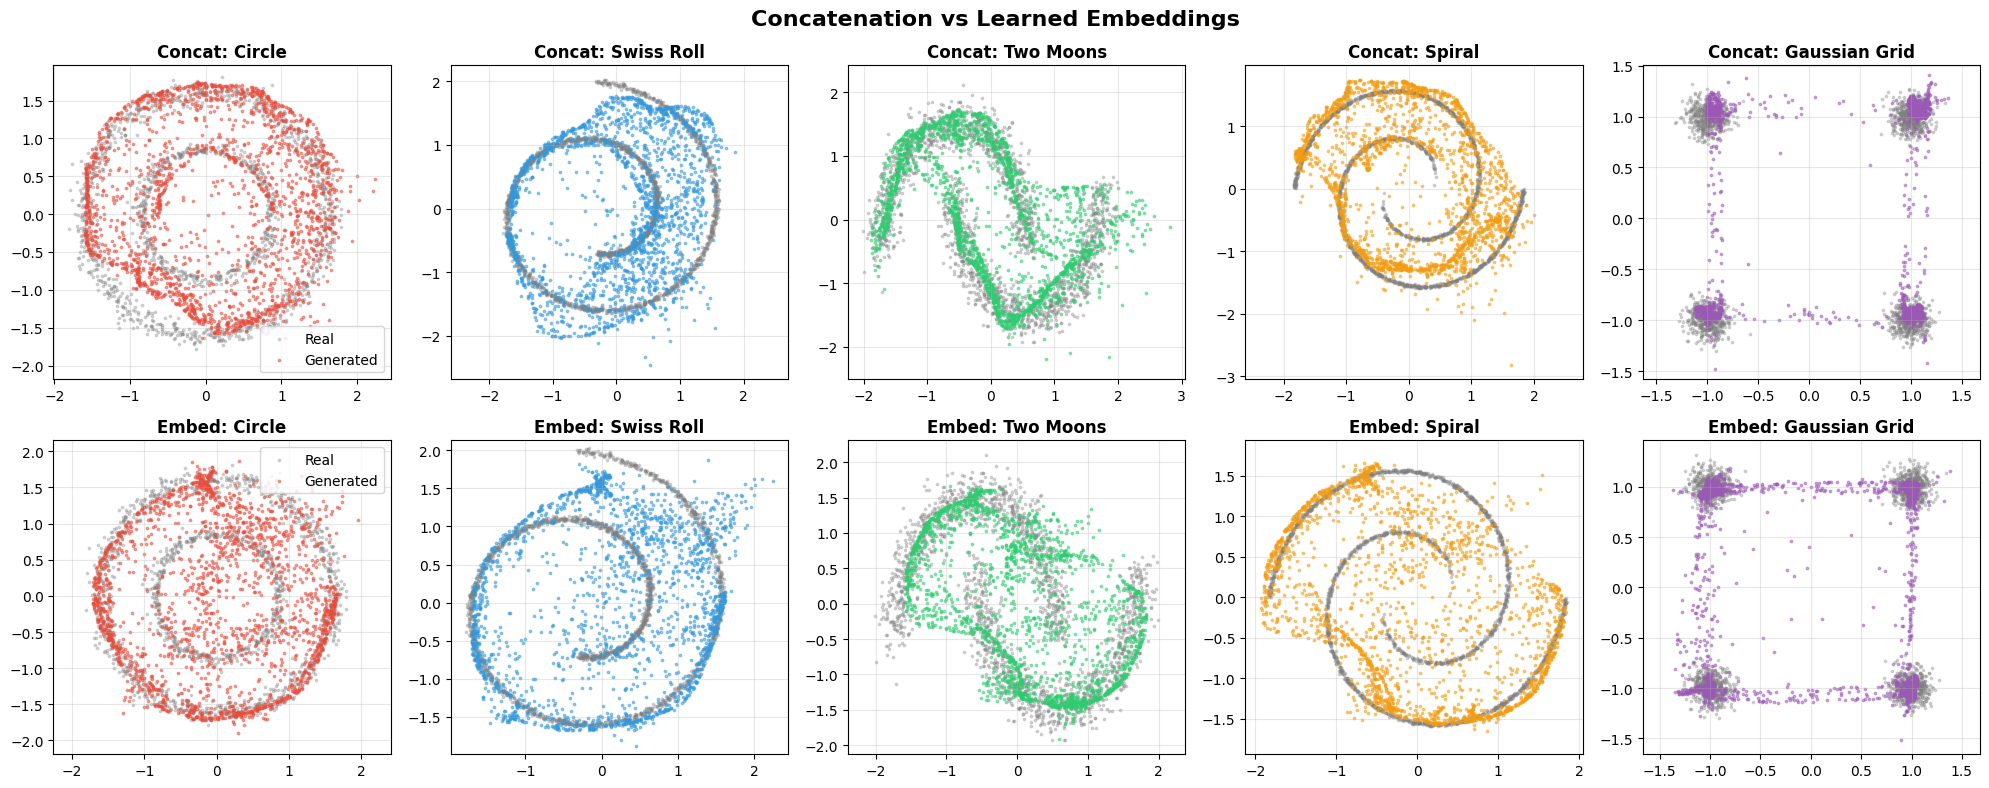

In [15]:
print("Training cGAN with Learned Embeddings...\n")
G_embed, D_embed, history_embed = train_conditional_gan(
    data=X_data,
    labels=y_labels,
    latent_dim=2,
    hidden_sizes=[128, 128, 128],
    batch_size=128,
    n_steps=10000,
    lr=1e-4,
    use_embedding=True,  # Use learned embeddings instead of one-hot
    print_every=2000,
    save_samples_every=10000,
    device=device
)
print("\nTraining complete!")

# Generate samples with embedding model
generated_embed = {}
with torch.no_grad():
    for class_idx in range(5):
        z = torch.randn(2000, 2).to(device)
        labels = torch.full((2000,), class_idx, dtype=torch.long, device=device)
        samples = G_embed(z, labels).cpu().numpy()
        generated_embed[class_idx] = samples

# Compare: Concatenation vs Embedding
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for class_idx in range(5):
    # Concatenation (original)
    mask = y_labels == class_idx
    axes[0, class_idx].scatter(X_data[mask, 0], X_data[mask, 1], 
                              s=3, alpha=0.3, c='gray', label='Real')
    axes[0, class_idx].scatter(generated_samples[class_idx][:, 0], 
                              generated_samples[class_idx][:, 1], 
                              s=3, alpha=0.5, c=colors[class_idx], label='Generated')
    axes[0, class_idx].set_title(f'Concat: {class_names[class_idx]}', fontweight='bold')
    axes[0, class_idx].axis('equal')
    axes[0, class_idx].grid(True, alpha=0.3)
    if class_idx == 0:
        axes[0, class_idx].legend()
    
    # Embedding
    axes[1, class_idx].scatter(X_data[mask, 0], X_data[mask, 1], 
                              s=3, alpha=0.3, c='gray', label='Real')
    axes[1, class_idx].scatter(generated_embed[class_idx][:, 0], 
                              generated_embed[class_idx][:, 1], 
                              s=3, alpha=0.5, c=colors[class_idx], label='Generated')
    axes[1, class_idx].set_title(f'Embed: {class_names[class_idx]}', fontweight='bold')
    axes[1, class_idx].axis('equal')
    axes[1, class_idx].grid(True, alpha=0.3)
    if class_idx == 0:
        axes[1, class_idx].legend()

plt.suptitle('Concatenation vs Learned Embeddings', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 8. Comparison with Vanilla GAN

Let's train a vanilla GAN (without conditioning) on the same mixed data to see why conditioning helps!

In [16]:
# Simple vanilla GAN classes (from the previous notebook)
class VanillaGenerator(nn.Module):
    def __init__(self, latent_dim, data_dim, hidden_sizes):
        super().__init__()
        layers = []
        prev = latent_dim
        for h in hidden_sizes:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(0.2, inplace=True)]
            prev = h
        layers.append(nn.Linear(prev, data_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.net(z)

class VanillaDiscriminator(nn.Module):
    def __init__(self, data_dim, hidden_sizes):
        super().__init__()
        layers = []
        prev = data_dim
        for h in hidden_sizes:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.1)]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x).view(-1)

# Train vanilla GAN
print("Training Vanilla GAN on mixed multi-class data...\n")

G_vanilla = VanillaGenerator(2, 2, [128, 128, 128]).to(device)
D_vanilla = VanillaDiscriminator(2, [128, 128, 128]).to(device)
G_vanilla.apply(init_weights)
D_vanilla.apply(init_weights)

g_opt = torch.optim.Adam(G_vanilla.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D_vanilla.parameters(), lr=1e-4, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()

dataset = TensorDataset(torch.tensor(X_data, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

n_steps = 20000
it = iter(loader)

for step in range(1, n_steps + 1):
    # Discriminator
    try:
        real = next(it)[0].to(device)
    except StopIteration:
        it = iter(loader)
        real = next(it)[0].to(device)
    
    z = torch.randn(len(real), 2, device=device)
    fake = G_vanilla(z).detach()
    
    d_real = D_vanilla(real)
    d_fake = D_vanilla(fake)
    
    d_loss = bce(d_real, torch.full_like(d_real, 0.9)) + bce(d_fake, torch.zeros_like(d_fake))
    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()
    
    # Generator
    z = torch.randn(128, 2, device=device)
    fake = G_vanilla(z)
    g_loss = bce(D_vanilla(fake), torch.ones_like(D_vanilla(fake)))
    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()
    
    if step % 2000 == 0:
        print(f"[{step:5d}/{n_steps}] D_loss={d_loss.item():.4f} | G_loss={g_loss.item():.4f}")

print("\nVanilla GAN training complete!")

# Generate samples from vanilla GAN
with torch.no_grad():
    z = torch.randn(10000, 2).to(device)
    vanilla_samples = G_vanilla(z).cpu().numpy()

Training Vanilla GAN on mixed multi-class data...

[ 2000/20000] D_loss=1.2706 | G_loss=1.0181
[ 4000/20000] D_loss=1.3295 | G_loss=0.8736
[ 6000/20000] D_loss=1.4321 | G_loss=1.1890
[ 8000/20000] D_loss=1.3037 | G_loss=0.9702
[10000/20000] D_loss=1.3873 | G_loss=0.7830
[12000/20000] D_loss=1.3686 | G_loss=0.8095
[14000/20000] D_loss=1.3644 | G_loss=0.8297
[16000/20000] D_loss=1.3768 | G_loss=0.7882
[18000/20000] D_loss=1.3674 | G_loss=0.8142
[20000/20000] D_loss=1.3817 | G_loss=0.8216

Vanilla GAN training complete!


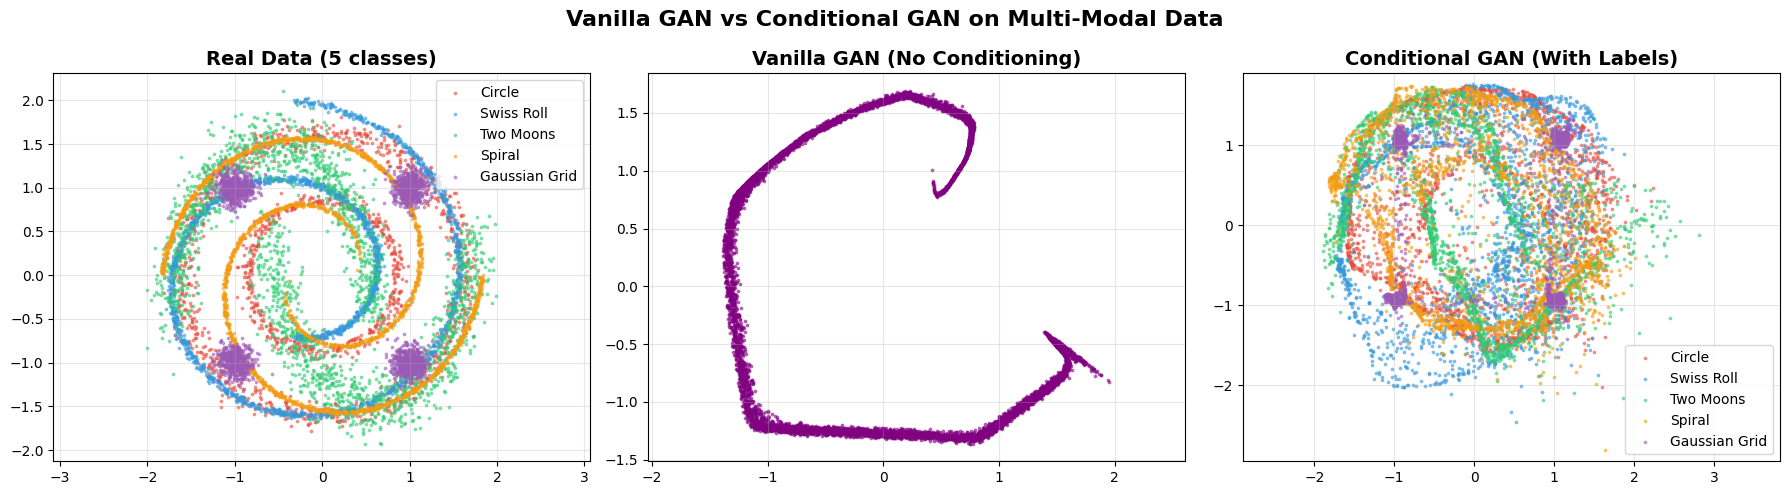


Key Observation:
- Vanilla GAN tries to capture all 5 distributions at once, often suffering from mode collapse
- Conditional GAN can generate each specific class on demand with high quality!


In [17]:
# Compare Vanilla GAN vs Conditional GAN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Real data (all classes)
for class_idx in range(5):
    mask = y_labels == class_idx
    axes[0].scatter(X_data[mask, 0], X_data[mask, 1], 
                   s=3, alpha=0.5, c=colors[class_idx], label=class_names[class_idx])
axes[0].set_title('Real Data (5 classes)', fontsize=14, fontweight='bold')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Vanilla GAN (struggles with multi-modal)
axes[1].scatter(vanilla_samples[:, 0], vanilla_samples[:, 1], 
               s=3, alpha=0.5, c='purple')
axes[1].set_title('Vanilla GAN (No Conditioning)', fontsize=14, fontweight='bold')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

# Conditional GAN (can generate each class)
for class_idx in range(5):
    gen_samples = generated_samples[class_idx]
    axes[2].scatter(gen_samples[:, 0], gen_samples[:, 1], 
                   s=3, alpha=0.5, c=colors[class_idx], label=class_names[class_idx])
axes[2].set_title('Conditional GAN (With Labels)', fontsize=14, fontweight='bold')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.suptitle('Vanilla GAN vs Conditional GAN on Multi-Modal Data', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Observation:")
print("- Vanilla GAN tries to capture all 5 distributions at once, often suffering from mode collapse")
print("- Conditional GAN can generate each specific class on demand with high quality!")